<a href="https://colab.research.google.com/github/TheCrypted/STAT-4830-project-base/blob/main/notebooks/notebook_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install osmnx


ERROR: Could not find a version that satisfies the requirement folium (from versions: none)
ERROR: No matching distribution found for folium


In [6]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx


Number of nodes: 13675
Number of edges: 31591


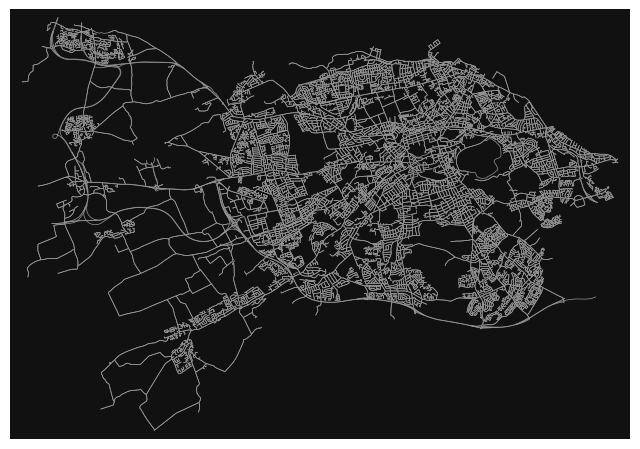

(<networkx.classes.multidigraph.MultiDiGraph at 0x19d7428ac80>,
                      y         x            highway  ref  street_count  \
 osmid                                                                    
 354026       55.925431 -3.415384  motorway_junction    2             3   
 354040       55.927636 -3.386314  motorway_junction    2             3   
 354097       55.921050 -3.319861                NaN  NaN             3   
 354100       55.924776 -3.310741                NaN  NaN             3   
 354815       55.943993 -3.405349                NaN  NaN             3   
 ...                ...       ...                ...  ...           ...   
 12438816803  55.932122 -3.129823                NaN  NaN             3   
 12469097114  55.931793 -3.203679                NaN  NaN             3   
 12480633444  55.947576 -3.178898     turning_circle  NaN             1   
 12500597978  55.930531 -3.124800                NaN  NaN             1   
 12512972718  55.928185 -3.127720   

In [7]:
def get_city_roads(city_name, network_type='drive'):
    # Configure OSMnx using settings
    ox.settings.use_cache = True
    ox.settings.log_console = True

    try:
        # Download street network
        G = ox.graph_from_place(city_name, network_type=network_type)

        # Convert to GeoDataFrame
        nodes, edges = ox.graph_to_gdfs(G)

        # Basic stats
        print(f"Number of nodes: {len(nodes)}")
        print(f"Number of edges: {len(edges)}")

        # Plot the street network
        fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)
        plt.show()

        return G, nodes, edges

    except Exception as e:
        print(f"Error fetching data: {str(e)}")
        return None, None, None


get_city_roads("edinburgh")

Number of nodes: 201
Number of edges: 566


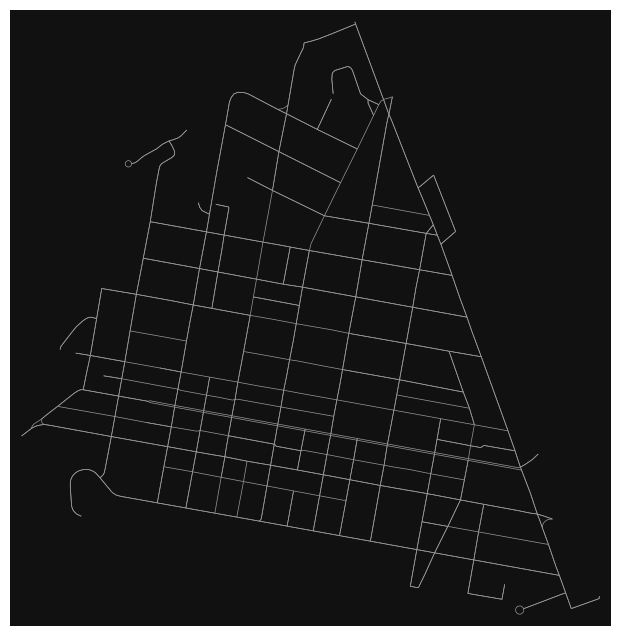


=== Road Attributes Analysis ===
Available attributes: ['osmid', 'highway', 'name', 'oneway', 'reversed', 'length', 'geometry', 'maxspeed', 'lanes', 'tunnel', 'bridge', 'ref']

HIGHWAY Distribution:
residential      419
primary           80
tertiary          60
living_street      5
primary_link       1
Name: highway, dtype: int64

LANES Distribution:
2         11
3          8
5          2
[3, 2]     2
Name: lanes, dtype: int64

=== Specific Queries ===

Longest road segment: 271.49 meters
Road name: North Monroe Street

Total length by road type (meters):
highway
living_street      444.557765
primary           6886.105814
primary_link        45.016237
residential      40108.922769
tertiary          4813.268110
tertiary_link       27.184864
Name: length, dtype: float64


In [9]:
def analyze_road_attributes(edges):
    """Analyze specific road attributes"""

    print("\n=== Road Attributes Analysis ===")

    # Available attributes
    print("Available attributes:", edges.columns.tolist())

    # Analyze specific attributes if they exist
    attributes_to_check = ['highway', 'lanes']

    for attr in attributes_to_check:
        if attr in edges.columns:
            print(f"\n{attr.upper()} Distribution:")
            print(edges[attr].value_counts().head())


# Usage example
city = "Media, Pennsylvania, USA"
G, nodes, edges = get_city_roads(city)

if G is not None:
    analyze_road_attributes(edges)

    # Additional specific queries
    print("\n=== Specific Queries ===")

    # Find longest road segment
    if 'length' in edges.columns:
        longest_road = edges.sort_values('length', ascending=False).iloc[0]
        print(f"\nLongest road segment: {longest_road['length']:.2f} meters")
        if 'name' in edges.columns and longest_road['name']:
            print(f"Road name: {longest_road['name']}")

    # Calculate total network length by road type
    if 'highway' in edges.columns and 'length' in edges.columns:
        length_by_type = edges.groupby('highway')['length'].sum()
        print("\nTotal length by road type (meters):")
        print(length_by_type)


In [10]:
def dijkstra(graph, start_node, end_node):
    
    distances = {node: float('inf') for node in graph.nodes}
    predecessors = {}
    distances[start_node] = 0
    unvisited = set(graph.nodes)

    while unvisited:
        current_node = min(unvisited, key=lambda node: distances[node])
        if distances[current_node] == float('inf'):
            break  # No path to remaining unvisited nodes

        if current_node == end_node:
            break  # Reached the destination node

        unvisited.remove(current_node)

        for neighbor, weight in graph[current_node].items():
            # Assuming edge data contains 'length' for weight.  Adapt if different.
            new_distance = distances[current_node] + weight.get('length', 1) # Default weight to 1 if 'length' is missing.
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                predecessors[neighbor] = current_node
    
    path = []
    current = end_node
    if end_node in predecessors:
      while current != start_node:
          path.insert(0, current)
          current = predecessors[current]
      path.insert(0, start_node)
      return path, distances[end_node]
    else:
      return None, float('inf')


In [11]:
graph_for_dijkstra = nx.Graph()
for u, v, data in G.edges(data=True):
  graph_for_dijkstra.add_edge(u, v, length=data.get("length", 1)) # Assumes the 'length' attribute exists

start_node_id = list(G.nodes)[0]  # Replace with an actual node ID
end_node_id = list(G.nodes)[-1]  # Replace with an actual node ID

shortest_path, shortest_distance = dijkstra(graph_for_dijkstra, start_node_id, end_node_id)


if shortest_path:
    print("Shortest path:", shortest_path)
    print("Shortest distance:", shortest_distance)
else:
    print(f"No path found between node {start_node_id} and {end_node_id}")

Shortest path: [109756437, 109988575, 109846233, 110006288, 110006302, 109984404, 110174840, 109793781, 10977632465]
Shortest distance: 753.0522164629363
